# ***Abdoul Aziz BERRADA - Amira SLIMENE - Yasmine Ouyahya***                                  
                                                                               

## ***Scoring et Risque de défaut***

### ***Scorecard building using HMEQ data***

In [3]:
import warnings
warnings.filterwarnings("ignore")
import time
import re
import utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.stats import skew
import scorecardpy as sc
import statsmodels.api as sm
from statsmodels.tools import tools
from statsmodels.iolib.summary import Summary
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, precision_recall_curve
from sklearn.metrics import make_scorer, auc, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
import pandas_profiling
from imblearn.over_sampling import SMOTE

## **1 - EXPLORATORY DATA EXPLORATION**

In [2]:
PATH = "https://raw.githubusercontent.com/aadmberrada/Linux_HMEQ/main/Ameliorations/2_Data/"
data = pd.read_csv(PATH + "hmeq.csv")
data.dtypes.value_counts()

float64    9
object     2
int64      2
dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


On a 13 variables réparties comme suit : 11 variables numériques dont 9 continues et 2 entières et 2 variables qualitatives

<AxesSubplot:ylabel='Types des variables'>

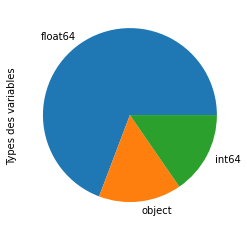

In [12]:
data.dtypes.value_counts().plot(kind="pie",ylabel='Types des variables')
#plt.show()

### Analyse univariate

In [11]:
data.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


Voici quelsques statistiques descriptives des variables numériques notre dataset :

On voit que :

- Pour la variable **LOAN**, on a une moyenne de 18607$ par montant demandé et 75% des prêts demandés sont 23300$; 
- Pour **DEBTINC** les valeurs varient entre 0.52% et 203.31% avec 50% des taux d'endettemnt supérieurs à 34.8%;
- Pour **VALUE** qui représente la valeur du bien actuel de l'emprunteur, on voit que les sont très dispérsées autour de la moyenne, l'écart type est très élevée et les biens valent en moyenne 101776$.

In [30]:
print(data['BAD'].value_counts())
print(data['BAD'].value_counts(normalize = True))

0    4771
1    1189
Name: BAD, dtype: int64
0    0.800503
1    0.199497
Name: BAD, dtype: float64


<AxesSubplot:xlabel='BAD', ylabel='count'>

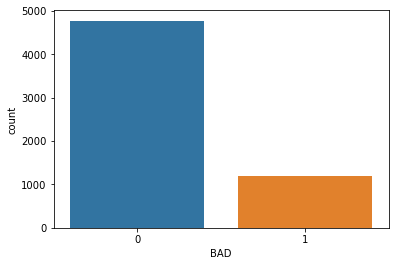

In [95]:
sns.countplot(x='BAD', data = data)

La cible **BAD** est une variable binaire indiquant si le client a payé son prêt ou s’il est en défaut de paiement. Cette issue défavorable s’est produite dans 1 189 cas (20 %).

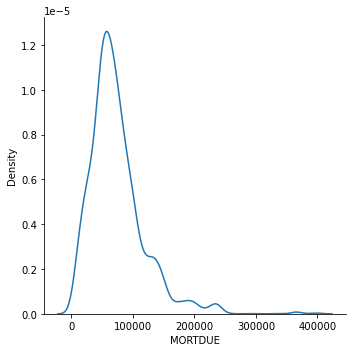

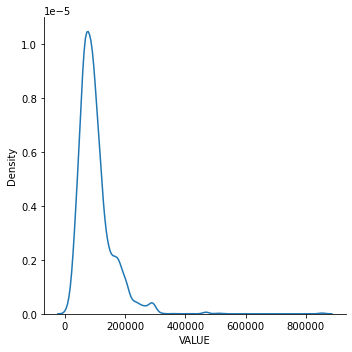

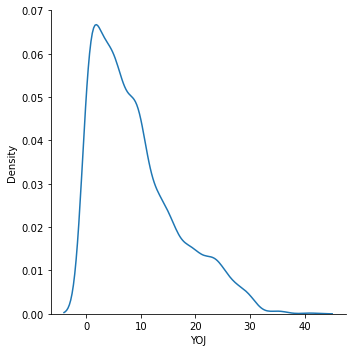

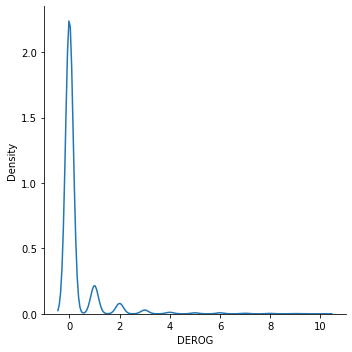

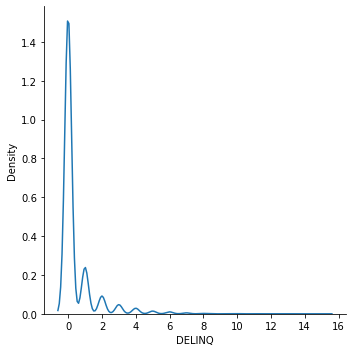

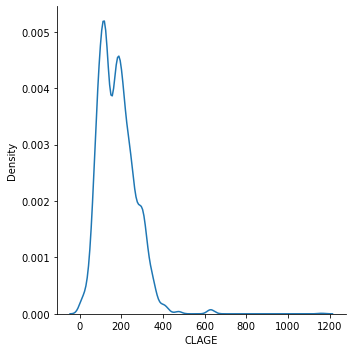

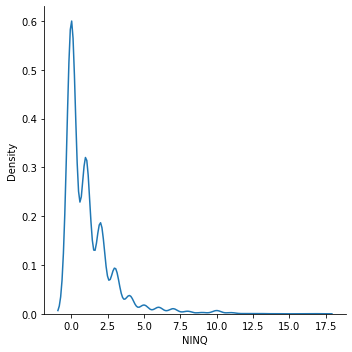

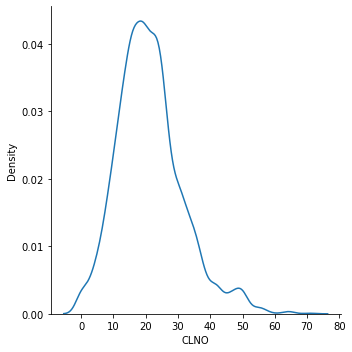

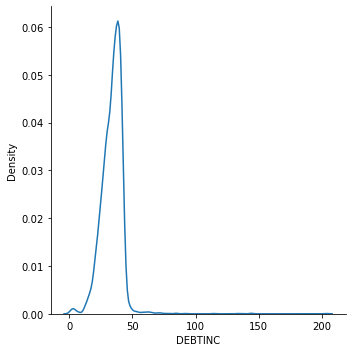

In [11]:
for col in data.select_dtypes('float'):
    sns.displot(data[col],kind="kde")

Une distribution désaxée vers la droite; une moyenne donc supérieure à la médiane distingue toutes les variables quantitatives de **DEBTINC**.
La médiane est une meilleure mesure de tendance centrale lorsque les distributions sont désaxées. 

Toutes  les variables quantitatives ont un écart à la moyenne faible donc elles sont bien centrées sauf pour **LOAN, MORTDUE, VALUE** qui ont un écart type important.

In [31]:
print(data['REASON'].value_counts())
print(data['REASON'].value_counts(normalize = True))

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64
DebtCon    0.688157
HomeImp    0.311843
Name: REASON, dtype: float64


In [34]:
print(data['JOB'].value_counts())
print(data['JOB'].value_counts(normalize = True))

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64
Other      0.420349
ProfExe    0.224608
Office     0.166872
Mgr        0.135011
Self       0.033973
Sales      0.019187
Name: JOB, dtype: float64


Concernant les 2 seules variables qualitatives, on voit que **REASON** qui indique le motif de demande du prêt a 2 modalités et la plus fréquente est ***DebtCon*** (Consolidation de dettes) à hauteur de 68.8% des cas et l'autre motif de prêt est ***HomeImp***. Les demandeurs de prêts font rouler leurs prêts, ils s'endettent de nouveau pour payer leurs anciens prêts. La variable **JOB** , elle distingue 6 types de demandeurs de prêts,  dans l'ordre d'importance on a : ***Other, ProfExe, Office, Mgr, Self et Sales***.

### Analyse multivariate

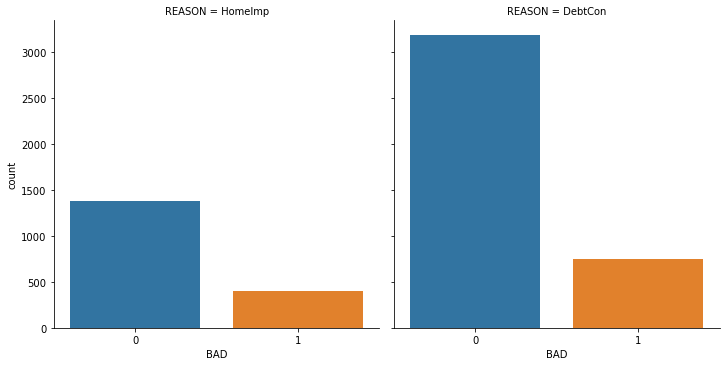

In [96]:
sns.catplot(x='BAD', col = 'REASON',kind='count', data=data)

On voit que parmi les emprunteurs, ceux qui demandent un nouveau prêt pour consolider l'ancien sont généralement ceux qui font le plus défaut.

<Figure size 1440x864 with 0 Axes>

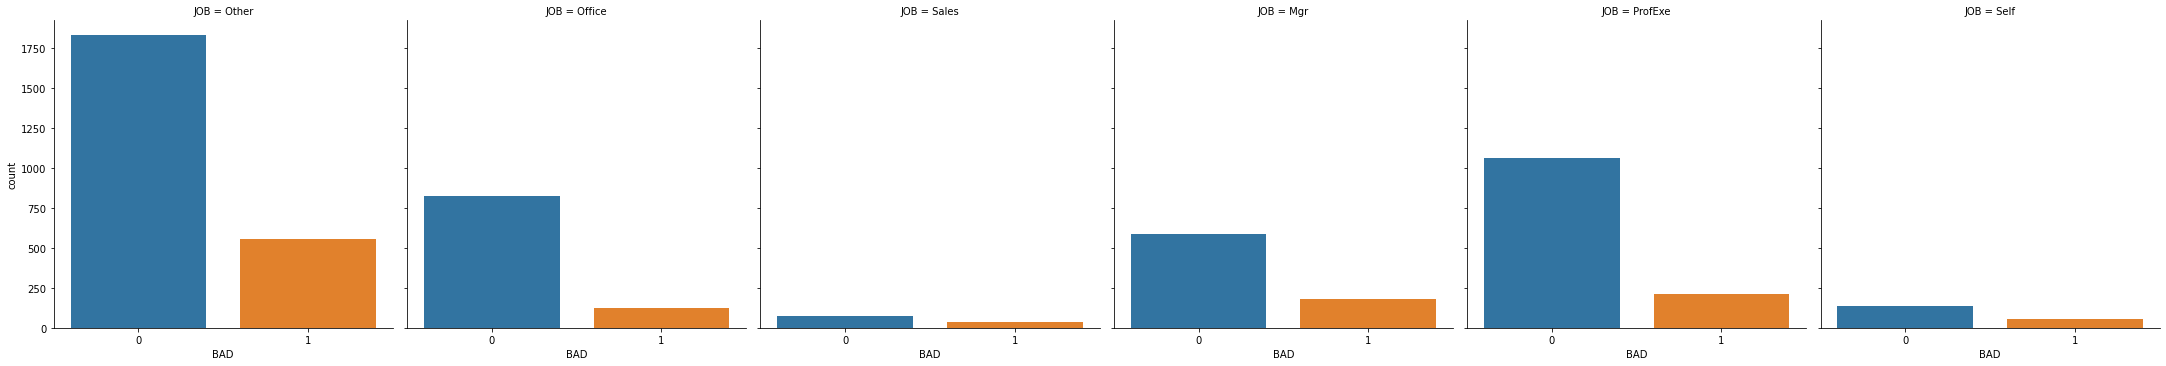

In [97]:
plt.figure(figsize = (20, 12))
sns.catplot(x='BAD', col = 'JOB',kind='count', data=data)

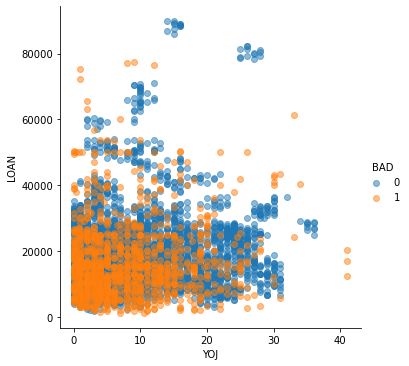

In [98]:
sns.lmplot(x='YOJ', y='LOAN', hue='BAD', data=data, fit_reg=False, scatter_kws={'alpha':0.5})

<Figure size 432x288 with 0 Axes>

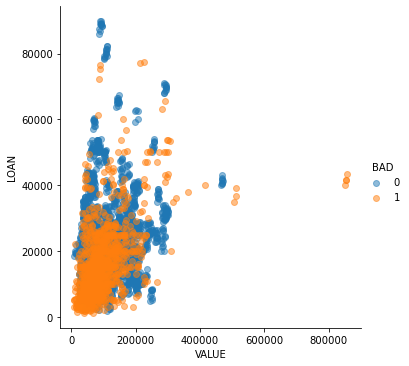

In [99]:
plt.figure()
sns.lmplot(x='VALUE', y='LOAN', hue='BAD', data=data, fit_reg=False, scatter_kws={'alpha':0.5})
plt.show()

On remarque que les montants prêtés augmentent au fur et à  mesure que le nombre d'année d'ancienneté augmente et d'autres part avec la hausse de la valeur du bien. La valeur du prêt est positivement corrélée à l'expérience professionnelle et à la valeur du logement. On remarquera aussi que les prêts en défaut sont majoritairement ceux des clients les moins expérimentés (- de 20 ans d'ancienneté) et des individus avec un montant d'hypothèque inférieur à 200000$ avec des prêts inférieurs à 40000$

<AxesSubplot:>

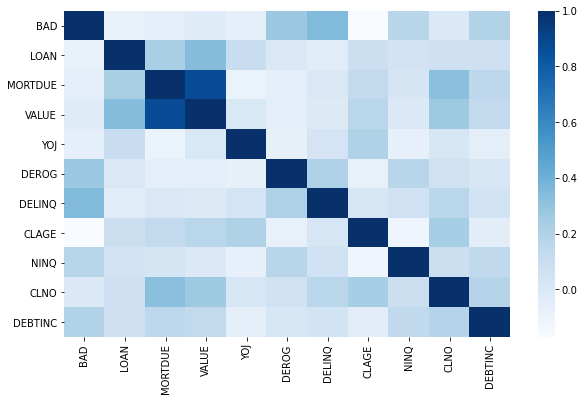

In [101]:
plt.figure(figsize = (10, 6))
sns.heatmap(data.corr(), cmap="Blues")

Le corrélogramme ci-dessous nous montre qu'il y a une  corrélation entre MORTDUE et VALUE ce qui est logique étant donné que la première variable dénote le montant dû sur l’hypothèque existante et VALUE la valeur actuelle de ce même bien. En revanche, les autres variables sont très faiblement corrélées ce qui est un bon indicateur pour avoir des coefficients de régression significatifs en absence de corrélations entre les variables explicatives.

## **2 - DATA CLEANING**

###  **Données manquantes**


La méthodologie employée pour imputer les données manquantes est la suivante : 

RQ : On considère qu'au delà de 40% de valeurs manquantes, une stratégie d'imputation risque d'introduire un biais dans l'analyse donc on va pas utiliser une telle variable par la suite.

- Variables quantitatives : 
On va se baser sur la distribution de la variable, si sa distribution est asymétrique, on va imputer par la médiane et sinon par la moyenne.
- Variables qualitatives : 
On va considérer le % de données manquantes, si celui-ci est inférieur à 15%, on va imputer par la valeur la plus fréquente (donc le mode), sinon on sera amené à créer une nouvelle classe nommée "autres". 

Les valeurs imputées dans le train_set seront repercutées dans le test_set

In [48]:
train, test = train_test_split(data, test_size = 0.2, random_state = 42)

In [49]:
print("data shape", data.shape)
print("test shape", test.shape)
print("train shape", train.shape)


data shape (5960, 13)
test shape (1192, 13)
train shape (4768, 13)


In [39]:
train.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [44]:
#prct_num, prct_qual = utils.prct_nan(train)

In [50]:
vars_num = [train.select_dtypes('float').columns]
vars_qual = [train.select_dtypes('object').columns]

In [41]:
#prct_num = [print((100*train[col].isna().sum()/train.shape[0]).sort_values(ascending = False)) for col in vars_num]
#prct_qual = [print((100*train[col].isna().sum()/train.shape[0]).sort_values(ascending = False)) for col in vars_qual]

In [51]:
prct_num, prct_qual = utils.prct_nan(train)

Pour les variables numériques, on a : 

DEBTINC    20.931208
DEROG      11.577181
DELINQ      9.584732
MORTDUE     8.640940
YOJ         8.473154
NINQ        8.389262
CLAGE       5.012584
CLNO        3.544463
VALUE       1.614933
dtype: float64
-----
Pour les variables quantitatives, on a : 

JOB       4.656040
REASON    4.089765
dtype: float64


In [52]:
prct_num, prct_qual = utils.prct_nan(test)

Pour les variables numériques, on a : 

DEBTINC    22.567114
DEROG      13.087248
DELINQ     10.318792
YOJ         9.312081
NINQ        9.228188
MORTDUE     8.892617
CLAGE       5.788591
CLNO        4.446309
VALUE       2.936242
dtype: float64
-----
Pour les variables quantitatives, on a : 

REASON    4.781879
JOB       4.781879
dtype: float64


In [53]:
train, test = utils.imputation(train, test)

AVANT IMPUTATION


**Variables quantitatives**:

---Train set----
Colonnes asymétriques dans le train ['MORTDUE', 'VALUE', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'DEBTINC']
Colonnes symétriques dans le train ['YOJ', 'CLNO']
----Test set----
Colonnes asymétriques dans le test ['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'NINQ', 'DEBTINC']
Colonnes symétriques dans le test ['CLAGE', 'CLNO']


**Variables qualitatives**:

---Train set----
Colonnes avec - de 15% de nan dans le train ['REASON', 'JOB']
Colonnes avec + de 15% de nan dans le train []
----Test set----
Colonnes avec - de 15% de nan dans le test ['REASON', 'JOB']
Colonnes avec + de 15% de nan dans le test []



APRÉS IMPUTATION
Valeurs manquantes dans le test set

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64


Valeurs manquantes dans le train set

BAD        0
LOAN       0
MORTDUE    0
VALUE     

In [54]:
data_clean = pd.concat([train.reset_index(drop=True), test.reset_index(drop=True)], axis= 0)

In [14]:
data_clean.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,9100,62976.0,77829.0,HomeImp,Mgr,0.000000,0.0,2.0,131.193496,0.0,23.0,26.090419
1,0,43800,5884.0,64890.0,HomeImp,Office,8.938187,0.0,0.0,309.827548,0.0,19.0,16.160451
2,0,13800,75142.0,95667.0,DebtCon,Mgr,19.000000,0.0,0.0,230.457554,10.0,24.0,33.383314
3,1,2000,45000.0,55000.0,HomeImp,Other,3.000000,0.0,0.0,86.066667,2.0,25.0,34.738063
4,0,9900,47367.0,114837.0,DebtCon,ProfExe,4.000000,0.0,0.0,210.435534,0.0,10.0,25.042109


## **3 - FEATURES SELECTION**

Afin de construire notre grille de score, on a décidé de discrétiser toutes nos variables explicatives.
Il y a beaucoup de justifications à la discrétisation des variables, une grille de score doit généralement
être facilement interprétable, étant donnés les coûts élevés des erreurs de classifications monétaires et
non monétaires. Cet objectif est facilement atteignable par un tableau de bord qui ne comporte aucune
variable continue, toutes les variables étant discrétisées. Les raisons des scores faibles ou élevés peuvent être facilement comprises et expliquées aux tiers. Tous ces éléments permettent aux grilles de scores
d’obtenir plus facilement l’adhésion des utilisateurs finaux contrairement aux modèles plus complexes.
Une grille de score doit être capable de séparer les observations à faible et à haut risque.
Mais comment allons nous discrétiser nos variables ? On va utiliser les WoE (Weights of Evidence) et
IV (Information Value). Les deux concepts sont très utilisés dans les étapes de features engineering et
features selection dans le domaine de l’évaluation du crédit

###    **3-1 WOE BINNING & IV**

La création de nouvelles caractéristiques catégorielles pour toutes les variables numériques et caté-
gorielles basées sur le WoE est l’une des étapes les plus critiques avant le développement d’un modèle de
risque de crédit. On génère un binning optimal pour les valeurs numériques, factorielles et catégorielles
en utilisant des méthodes comprenant la segmentation arborescente ou le chi carré pour fusionner des
modalités. C’est une mesure du pouvoir prédictif d’une variable indépendante par rapport à la variable
cible. Elle indique dans quelle mesure une caractéristique spécifique peut différencier les classes cibles,
dans notre cas : les bons et les mauvais clients.

La formule pour calculer le WoE est la suivante :
$$WoE = \ln(\frac{\%defaut}{\%non-defaut})$$
Un WoE positif signifie que la proportion de bons clients est supérieure à celle des mauvais clients et
vice versa pour une valeur WoE négative.

Nous discrétisons les variables en classes distinctes (chacune avec un WoE différent), ce qui donne plusieurs catégories, ainsi les nouveaux emprunteurs potentiels seraient classés dans l'une des catégories en fonction de leurs caractéristiques. 

L'objectif ultime est de faire un binning qui implique une monotonicité de la proportion de clients en défaut dans chaque classe créée


In [15]:
classes = sc.woebin(data_clean, y="BAD", positive=1, method="chimerge")

[INFO] creating woe binning ...
Binning on 5960 rows and 13 columns in 00:00:19


L'IV aide à classer les variables explicatives (les caractéristiques des clients) en fonction de leur importance relative.
Les analyses WOE et IV permettent de :
- Considérer la contribution indépendante de chaque variable au résultat.
- Détecter les relations linéaires et non linéaires
- Classer les variables en fonction de leur force prédictive univariée
- Visualiser les corrélations entre les variables et la  valeur cible binaire.


La formule pour calculer la IV est la suivante :
$\begin{equation}
IV=\sum( \text { \% of good customers } - \text { \% of bad customers) } \times \text { WoE }
\end{equation}$

{'JOB': <Figure size 432x288 with 2 Axes>,
 'CLNO': <Figure size 432x288 with 2 Axes>,
 'CLAGE': <Figure size 432x288 with 2 Axes>,
 'LOAN': <Figure size 432x288 with 2 Axes>,
 'MORTDUE': <Figure size 432x288 with 2 Axes>,
 'VALUE': <Figure size 432x288 with 2 Axes>,
 'NINQ': <Figure size 432x288 with 2 Axes>,
 'YOJ': <Figure size 432x288 with 2 Axes>,
 'DEROG': <Figure size 432x288 with 2 Axes>,
 'DELINQ': <Figure size 432x288 with 2 Axes>,
 'DEBTINC': <Figure size 432x288 with 2 Axes>,
 'REASON': <Figure size 432x288 with 2 Axes>}

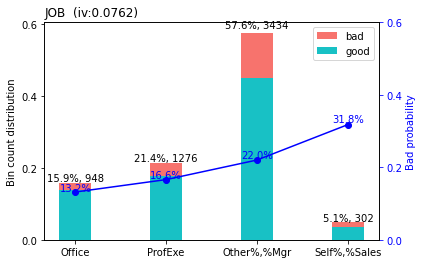

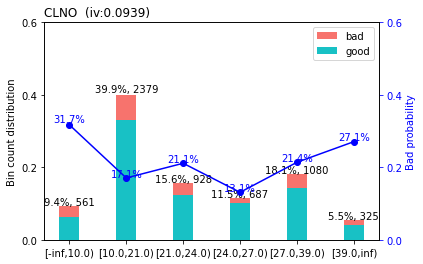

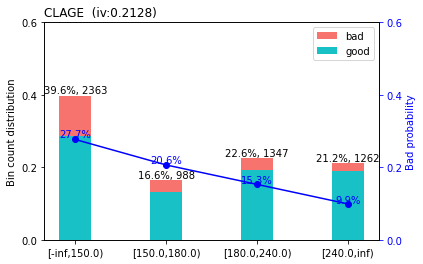

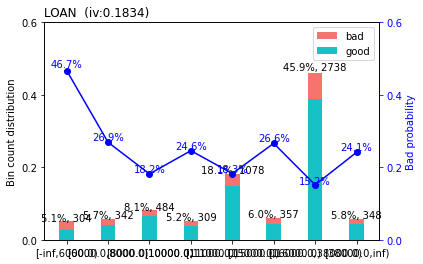

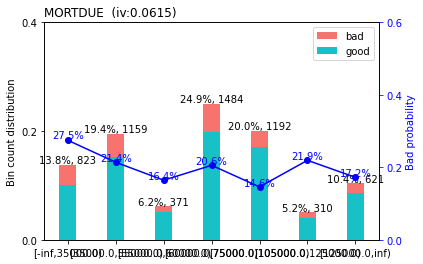

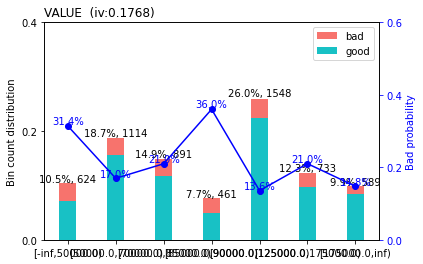

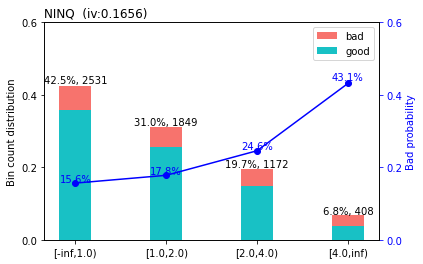

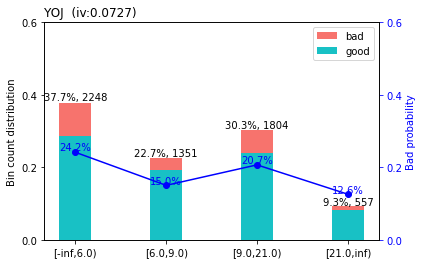

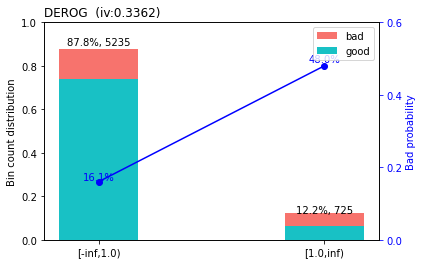

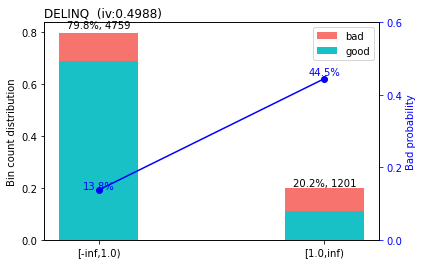

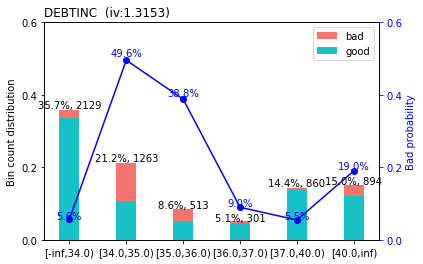

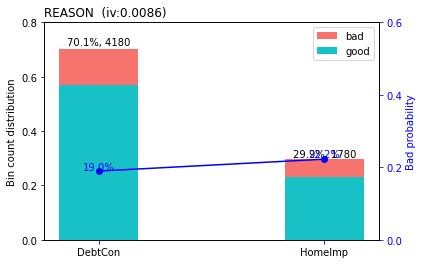

In [16]:
sc.woebin_plot(classes)

In [23]:
classes["LOAN"]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LOAN,"[-inf,6000.0)",304,0.051007,162,142,0.467105,1.257674,0.107497,0.183383,6000.0,False
1,LOAN,"[6000.0,8000.0)",342,0.057383,250,92,0.269006,0.389771,0.009735,0.183383,8000.0,False
2,LOAN,"[8000.0,10000.0)",484,0.081208,396,88,0.181818,-0.114634,0.001031,0.183383,10000.0,False
3,LOAN,"[10000.0,11000.0)",309,0.051846,233,76,0.245955,0.269138,0.004059,0.183383,11000.0,False
4,LOAN,"[11000.0,15000.0)",1078,0.180872,881,197,0.182746,-0.108411,0.002057,0.183383,15000.0,False
5,LOAN,"[15000.0,16000.0)",357,0.059899,262,95,0.266106,0.374976,0.009368,0.183383,16000.0,False
6,LOAN,"[16000.0,38000.0)",2738,0.459396,2323,415,0.151570,-0.332893,0.045895,0.183383,38000.0,False
7,LOAN,"[38000.0,inf)",348,0.058389,264,84,0.241379,0.244311,0.003741,0.183383,inf,False


In [17]:
classes["VALUE"]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,VALUE,"[-inf,50000.0)",624,0.104698,428,196,0.314103,0.608435,0.045715,0.1768,50000.0,False
1,VALUE,"[50000.0,70000.0)",1114,0.186913,925,189,0.169659,-0.198603,0.006936,0.1768,70000.0,False
2,VALUE,"[70000.0,85000.0)",891,0.149497,704,187,0.209877,0.063774,0.000620,0.1768,85000.0,False
3,VALUE,"[85000.0,90000.0)",461,0.077349,295,166,0.360087,0.814456,0.063349,0.1768,90000.0,False
4,VALUE,"[90000.0,125000.0)",1548,0.259732,1338,210,0.135659,-0.462380,0.048007,0.1768,125000.0,False
5,VALUE,"[125000.0,175000.0)",733,0.122987,579,154,0.210095,0.065093,0.000531,0.1768,175000.0,False
6,VALUE,"[175000.0,inf)",589,0.098826,502,87,0.147708,-0.363249,0.011642,0.1768,inf,False


On voit que pour la variable **LOAN** et **VALUE** ci-dessus, on a les classes qui sont générés, les effectifs de chaque classe de ainsi que les WOE et IV correspondant.

In [18]:
# On applique les classes crées au test et train set
train_woe = sc.woebin_ply(train, classes)
test_woe = sc.woebin_ply(test, classes)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [19]:
train_woe.head()

,BAD,JOB_woe,CLNO_woe,CLAGE_woe,LOAN_woe,MORTDUE_woe,VALUE_woe,NINQ_woe,YOJ_woe,DEROG_woe,DELINQ_woe,DEBTINC_woe,REASON_woe
0,1,0.124659,0.623192,0.428887,1.257674,0.418061,0.608435,-0.140965,0.044893,-0.26396,-0.445639,1.372024,0.138124
1,1,0.124659,-0.191514,0.428887,1.257674,0.037333,-0.198603,-0.295364,-0.343127,-0.26396,1.167049,1.372024,0.138124
2,1,0.124659,-0.191514,0.428887,1.257674,0.418061,0.608435,-0.140965,0.245232,-0.26396,-0.445639,1.372024,0.138124
3,1,0.124659,0.071777,0.043154,1.257674,0.037333,0.814456,-0.140965,-0.343127,-0.26396,-0.445639,1.372024,-0.062433
4,0,-0.495199,-0.191514,0.428887,1.257674,-0.377097,-0.462380,-0.295364,0.245232,-0.26396,-0.445639,1.372024,0.138124


In [20]:
# Création de couple target - features dans le train  et test set
y_train = train_woe["BAD"]
X_train = train_woe.drop(["BAD",'REASON_woe' ], axis =1)

y_test = test_woe["BAD"]
X_test = test_woe.drop(["BAD", 'REASON_woe'], axis =1)

In [21]:
print("Les features sélectionnées sont:")
print(X_train.columns)
print("Elles sont au nombre de", X_train.shape[1])

Les features sélectionnées sont:
Index(['JOB_woe', 'CLNO_woe', 'CLAGE_woe', 'LOAN_woe', 'MORTDUE_woe',
       'VALUE_woe', 'NINQ_woe', 'YOJ_woe', 'DEROG_woe', 'DELINQ_woe',
       'DEBTINC_woe'],
      dtype='object')
Elles sont au nombre de 11


###    **3-2 AUTOMATIC SELECTION**

Pour sélectionner les meilleures variables à mettre en input dans notre modèle, on a jugé nécessaire d'appliquer différents algorithmes de sélection autonmatiques de variables. Ces algorithmes en question sont la Recursive Feature Elimination, la Sequential Feature Selector et Exhaustive Feature Selector. On a alors appliqué une régression logistique à chaque algorithme en maximisant l'AUC pour au final obtenir les variables les plus pertinentes qui seront sélectionnées.

In [25]:
all_scores_dict = utils.selection_np(RFE, LogisticRegression(), X_train, y_train, X_test, Forward = False, metric='roc_auc')
all_scores_dict

{'Selector': 'RFE',
 'Estimateur': 'LogisticRegression()',
 'Score': 0.887256441559867,
 'N_Variables': 11,
 'Variables': ['JOB_woe',
  'CLNO_woe',
  'CLAGE_woe',
  'LOAN_woe',
  'MORTDUE_woe',
  'VALUE_woe',
  'NINQ_woe',
  'YOJ_woe',
  'DEROG_woe',
  'DELINQ_woe',
  'DEBTINC_woe'],
 'Duree(s)': 1.6585369110107422}

In [30]:
selectors = [RFE, SequentialFeatureSelector, ExhaustiveFeatureSelector]
algos = [LogisticRegression(random_state=42)]
recaps = utils.selection_list(selectors, algos, X_train, y_train, X_test, metric = "roc_auc", smote = True)
recaps

Features: 562/562

,Selector,Estimateur,Score,N_Variables,Duree(s),Variables
1,SequentialFeatureSelector,LogisticRegression(random_state=42),0.883275,10,5.181867,"[JOB_woe, CLNO_woe, CLAGE_woe, MORTDUE_woe, VA..."
2,ExhaustiveFeatureSelector,LogisticRegression(random_state=42),0.883275,10,52.060789,"[JOB_woe, CLNO_woe, CLAGE_woe, MORTDUE_woe, VA..."
0,RFE,LogisticRegression(random_state=42),0.881955,11,2.060958,"[JOB_woe, CLNO_woe, CLAGE_woe, LOAN_woe, MORTD..."


In [31]:
list_vars = recaps.iloc[2, 5]
selector = recaps.iloc[2, 0]
estimateur = recaps.iloc[2, 1]

nb_vars = recaps.iloc[2, 3]
X_train = X_train[list_vars]
X_test = X_test[list_vars]
#print("X_train shape :", X_train.shape)
print("L'estimateur", estimateur, "avec la méthode", selector, "a selectionné", nb_vars, "variables :", list_vars)

L'estimateur LogisticRegression(random_state=42) avec la méthode RFE a selectionné 11 variables : ['JOB_woe', 'CLNO_woe', 'CLAGE_woe', 'LOAN_woe', 'MORTDUE_woe', 'VALUE_woe', 'NINQ_woe', 'YOJ_woe', 'DEROG_woe', 'DELINQ_woe', 'DEBTINC_woe']


### ***3-3 SIGNIFICATIVITE NON NULLE***

In [29]:
utils.val(X_train, y_train)

Optimization terminated successfully.
         Current function value: 0.313470
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.362    
Dependent Variable: BAD              AIC:              3013.2533
Date:               2021-11-19 01:42 BIC:              3090.8895
No. Observations:   4768             Log-Likelihood:   -1494.6  
Df Model:           11               LL-Null:          -2344.3  
Df Residuals:       4756             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
const           -1.4371   0.0497 -28.9167 0.0000 -1.5345 -1.3397
JOB_woe          0.8457   0.1709   4.9488 0.0000  0.5108  1.1807
CLNO_woe     

On remarque que toutes les varaibles sont statistiquement différentes de 0. Donc on peut les selectionner dans notre modèle final.

## ***4 - MODEL SELECTION - PARAMETERS SELECTION***

Maintenant qu'on a les bonnes variables à mettre dans notre modèle, on va désormais chercher les meilleurs paramètres de notre modèle.

Mais avant vérifions si on overfit ou pas

In [32]:
utils.overfit(['roc_auc', 'accuracy', "recall", 'precision', 'f1'], X_train, y_train ).round(3)

Mean Auc: 0.88
Gini: 0.76


,fit_time,score_time,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1
0,0.017,0.009,0.887,0.882,0.864,0.868,0.492,0.522,0.717,0.721,0.583,0.606
1,0.015,0.008,0.859,0.889,0.862,0.872,0.497,0.535,0.702,0.733,0.582,0.618
2,0.017,0.008,0.855,0.890,0.856,0.870,0.486,0.528,0.682,0.726,0.568,0.611
3,0.016,0.008,0.915,0.875,0.875,0.866,0.524,0.498,0.758,0.723,0.620,0.590
4,0.014,0.008,0.893,0.881,0.873,0.867,0.560,0.509,0.720,0.722,0.630,0.597
5,0.015,0.008,0.897,0.880,0.883,0.866,0.492,0.501,0.835,0.723,0.619,0.592
6,0.015,0.008,0.883,0.883,0.867,0.870,0.514,0.518,0.720,0.734,0.599,0.607
7,0.015,0.008,0.897,0.879,0.866,0.868,0.578,0.506,0.682,0.729,0.626,0.597
8,0.016,0.008,0.867,0.887,0.847,0.871,0.481,0.536,0.640,0.724,0.549,0.616
9,0.018,0.008,0.860,0.889,0.865,0.871,0.489,0.536,0.720,0.724,0.583,0.616


On remarque qu'en utilisant la méthode des K-Folds avec k=10, le modèle est capable de généraliser ses performances. En effet les performances dans le train et le test sont très proches, le modèle n'overfitte pas.

Cherchons maintenant les meilleurs paramètres par la méthode du GridSearchCV

In [33]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 
           'Recall': make_scorer(recall_score), 'f1_score': make_scorer(f1_score),
          'Precision': make_scorer(precision_score)}

param={"penalty":["l2", "l1", "elasticnet"], 
       'C':[5,10,15,20], 
       "max_iter":[100,150,200]}

gs = GridSearchCV(LogisticRegression(random_state=42),
                  param_grid=param,
                  scoring=scoring, refit='AUC', return_train_score=True, cv = 5)

gs.fit(X_train, y_train)
results = gs.cv_results_

print("Les meilleurs paramètres sont:", gs.best_params_)
print("Le meilleur score est: %.2f" %gs.best_score_)

Les meilleurs paramètres sont: {'C': 15, 'max_iter': 100, 'penalty': 'l2'}
Le meilleur score est: 0.89


On peut maintenant évaluer les performances de notre modèle en prenant de rééchantilloner notre dataset.

SMOTE
--------
train score 0.81
--------
test score 0.80
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       927
           1       0.50      0.80      0.61       265

    accuracy                           0.78      1192
   macro avg       0.71      0.78      0.73      1192
weighted avg       0.83      0.78      0.79      1192



Matrice de confusion

[[716 211]
 [ 54 211]]
--------
L'AUC est de 0.88
--------
Gini test: 0.75
--------
Gini train: 0.77
--------
roc curve


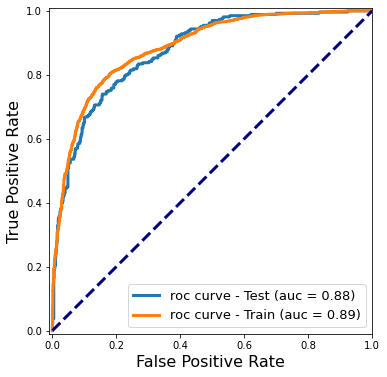



precision_recall_curve


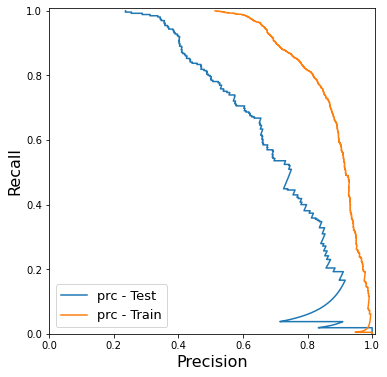

Meilleur cut-off test : 0.08
Meilleur cut-off train : 0.12


In [34]:
train_pred, y_test, test_pred, fpr, tpr, roc_auc = utils.model_perf(X_train, y_train, X_test, y_test, smote = True, show_roc= True, show_prc=True, cut_off= 0.45, show_conf_matrix=True)

On a un recall très élevé et une précision très faible. Même si notre problème est orienté recall, on préfère garder un certain équilibre entre ces 2 métriques afin d'avoir un f1 score appréciable.

Dans notre cas, on a procédé par tâtonnement et puis fixé ce cutoff à 0,45. Toutes les observations dont la probabilité prédite est supérieure à ce seuil doivent être classées dans la catégorie Défaut (classe 1) et Non Défaut (Classe 0) sinon.

## ***5 - SCORECARD***

Notre Grille de score est calibrée sur 1000 points, plus le score est élevé, moins le client a de risque de faire défaut. On fixe les Odds à $\frac{1}{500}$ (500:1) et les PDO (Points Double the Odds) à 30 points. 

Ainsi une personne qui a un  score 1000 points  a une probabilité de défaut de 1/500 alors qu'une personne qui a un score de 1030 (1000 + 30) elle a une une probabilité de défaut égale à $\frac{1}{1000}$ (1000:1 = 2*500:1).

En pratique, la Grille de score est déterminée de la façon suivante :

- On détermine la probabilité de défaut $p(y=1)$ par : 

    $\begin{equation}
       p(y=1) =  \frac{1}{1+exp(-Z)} 
    \end{equation}$
avec z qui est la combinaison linéaire des WOE de toutes les variables sélectionnées en entrée 

 $\begin{equation}
    Z   =  b_0 + b_1*WOE_1 + b_2*WOE_2+ ... +b_k*WOE_k 
\end{equation}$
$\begin{equation}
    Z =  log(\frac{p}{1-p})
    \end{equation}$

Mais comme on sait que :  
    $\begin{equation}
        Odds   =  \frac{p}{1-p} 
    \end{equation}$
donc
    $\begin{equation}
        Z  = log(Odds)
    \end{equation}$
- Ensuite on va directement déterminer les points par les formules suivantes : 
    $\begin{equation}
    Points   =  Shift + Slope*Z
    \end{equation}$
    $\begin{equation}
    Points + PDO  =  Shift + Slope*log(2*Odds)
    \end{equation}$
RQ : Le PDO est positif pour garantir le fait que les scores les plus élevés engendrent les risques les plus faibles.

In [88]:
def scoring(X, base = 1000, pdo = 30):
    
    #CREATION DE LA GRILLE SCORE À PARTIR DES CLASSES, DU MODÈLE M ET CALIBRAGE SUR "base" POINTS
    lr = LogisticRegression(penalty='l2', C=5, max_iter= 100, random_state=42)
    lr.fit(X_train, y_train)
    test_pred = lr.predict_proba(X_test)[:,1]
    
    ppb = sc.scorecard(classes, lr, xcolumns=X_test.columns, 
                       odds0=1/500,  points0=base, pdo=pdo, basepoints_eq0 = True)
    
    
        #CALCUL DES SCORES TOTAUX DANS LE TRAIN SET
    train_score = sc.scorecard_ply(train, ppb, print_step=0, only_total_score=False)
        #CALCUL DES SCORES DANS LE TEST SET
    test_score = sc.scorecard_ply(test, ppb, print_step=0, only_total_score=False)

    if X == "Test":
        a = test_score
        b = test
    else:
        X == "Train"
        a = train_score
        b = train
        
    score_avec_target = pd.concat([a, b['BAD']],axis=1)
    #score_total       = score_avec_target['score']
    bon_score         = score_avec_target[score_avec_target["BAD"]== 0]['score']
    mauvais_score     = score_avec_target[score_avec_target["BAD"]== 1]['score']


    plt.figure()
    sns.distplot(mauvais_score, color='red', label = "BAD = 1")
    sns.distplot(bon_score, color = "green", label ="BAD = 0" )
    plt.legend(loc='upper left')
    plt.title("score distribution - " + str(X))

        
    plt.figure()
    sns.distplot(train_score["score"], color='blue', label = "train score")
    sns.distplot(test_score["score"], color = "orange", label ="test score" )
    plt.legend(loc='upper left')
    plt.title("Test & Train Comparaison")
    
    return ppb, train_score, test_score

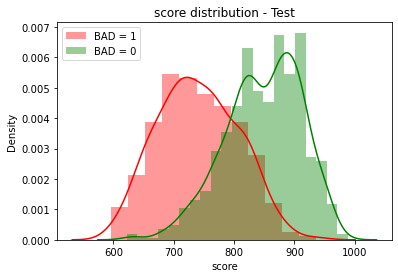

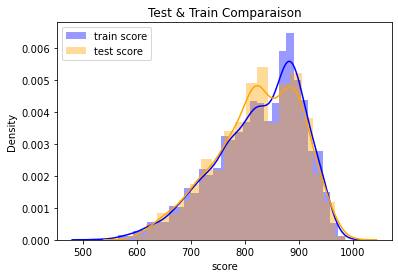

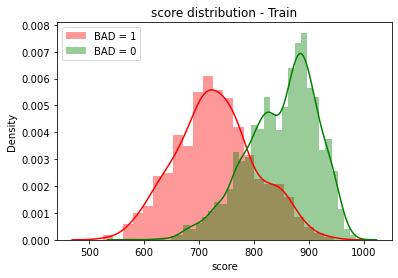

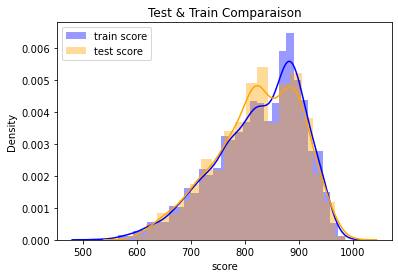

In [89]:
# On détermine les score dans le train et le test set
ppb, train_score, test_score= scoring("Test")
ppb, train_score, test_score= scoring("Train")

In [38]:
test_score.describe()["score"]

count    1192.000000
mean      824.329698
std        77.679569
min       596.000000
25%       772.000000
50%       830.500000
75%       886.000000
max       988.000000
Name: score, dtype: float64

In [39]:
train_score.describe()["score"]

count    4768.000000
mean      826.513633
std        80.741312
min       525.000000
25%       773.000000
50%       839.000000
75%       889.000000
max       986.000000
Name: score, dtype: float64


La contribution de variable j pour l'individu i est donnée par  :

$\begin{equation}
Points_ji = Slope*(b_j*WOE_j(i)).
\end{equation}$

Par défaut, les points de base ne sont pas équi-distribués; dans notre cas on a décidé que les points de base soient également distribués à chaque variable donc: 
$\begin{equation}
Points_ji = \frac{Shift + Slope*b_0}{k + Slope*(b_j*WOE_j(i))}
\end{equation}$
avec k le nombre de variables dans le modèle et $Base points = Shift + Slope*b_0$.

In [40]:
test_score.head()

,JOB_points,CLNO_points,CLAGE_points,LOAN_points,MORTDUE_points,VALUE_points,NINQ_points,YOJ_points,DEROG_points,DELINQ_points,DEBTINC_points,score
8,68.0,81.0,85.0,38.0,64.0,55.0,76.0,62.0,80.0,25.0,35.0,669.0
14,68.0,81.0,55.0,38.0,71.0,70.0,80.0,86.0,80.0,25.0,35.0,689.0
15,68.0,44.0,105.0,38.0,64.0,55.0,80.0,86.0,80.0,25.0,35.0,680.0
17,68.0,69.0,70.0,38.0,64.0,50.0,76.0,70.0,80.0,90.0,129.0,804.0
23,68.0,81.0,55.0,38.0,64.0,50.0,80.0,94.0,80.0,25.0,35.0,670.0


Le dataframe ci-dessus nous donne pour les 5 premiers individus du test set les points que leur confère chaque variable en fonction de leurs caractéristiques et la dernière colonne est leur score cumulé.

In [41]:
ppb

{'basepoints':      variable  bin  points
 0  basepoints  NaN       0,
 'JOB':   variable           bin  points
 0      JOB        Office    90.0
 1      JOB       ProfExe    80.0
 2      JOB   Other%,%Mgr    68.0
 3      JOB  Self%,%Sales    49.0,
 'CLNO':   variable          bin  points
 4     CLNO  [-inf,10.0)    44.0
 5     CLNO  [10.0,21.0)    81.0
 6     CLNO  [21.0,24.0)    69.0
 7     CLNO  [24.0,27.0)    95.0
 8     CLNO  [27.0,39.0)    68.0
 9     CLNO   [39.0,inf)    54.0,
 'CLAGE':    variable            bin  points
 10    CLAGE   [-inf,150.0)    55.0
 11    CLAGE  [150.0,180.0)    70.0
 12    CLAGE  [180.0,240.0)    85.0
 13    CLAGE    [240.0,inf)   105.0,
 'LOAN':    variable                bin  points
 14     LOAN      [-inf,6000.0)    38.0
 15     LOAN    [6000.0,8000.0)    62.0
 16     LOAN   [8000.0,10000.0)    75.0
 17     LOAN  [10000.0,11000.0)    65.0
 18     LOAN  [11000.0,15000.0)    75.0
 19     LOAN  [15000.0,16000.0)    62.0
 20     LOAN  [16000.0,38000.0)  

In [42]:
ppb['VALUE']

,variable,bin,points
29,VALUE,"[-inf,50000.0)",55.0
30,VALUE,"[50000.0,70000.0)",78.0
31,VALUE,"[70000.0,85000.0)",70.0
32,VALUE,"[85000.0,90000.0)",50.0
33,VALUE,"[90000.0,125000.0)",85.0
34,VALUE,"[125000.0,175000.0)",70.0
35,VALUE,"[175000.0,inf)",82.0


Nous allons tester la stabilité des deux distributions de scores dans le train et le test set, on obtient un PSI=0.0162 (PSI : Population Stability Index). L'indice de stabilité de la population (ISP) est utilisé pour mesurer l'applicabilité d'un modèle en mesurant le changement des variables indépendantes ou dépendantes.Il compare la distribution d'une variable de notation (probabilité prédite) dans un ensemble de données de notation à un ensemble de données d'entraînement qui a été utilisé pour développer le modèle. 
L'idée est de vérifier "comment le score actuel est comparé à la probabilité prédite à partir de l'ensemble de données du train set."

Pour chaque variable, on a déterminé la stabilité du taux de défaut pour toutes les classes précédemment créées dans le test et le train. Cette stabilité permet de bien pouvoir généraliser les résultats.

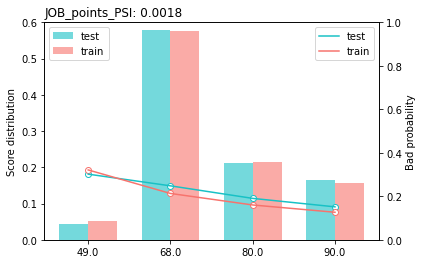

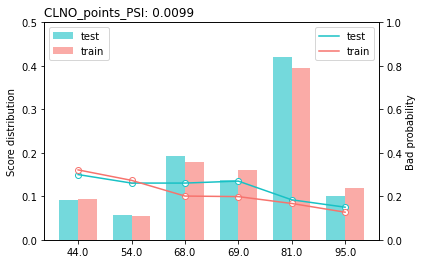

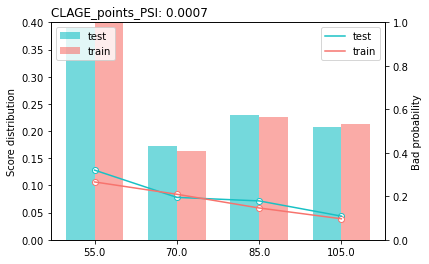

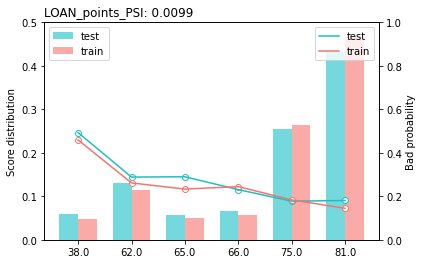

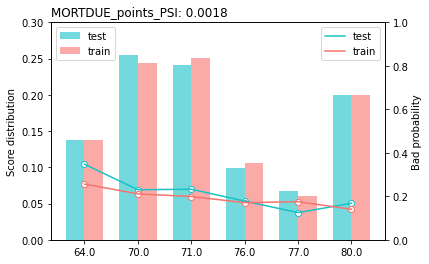

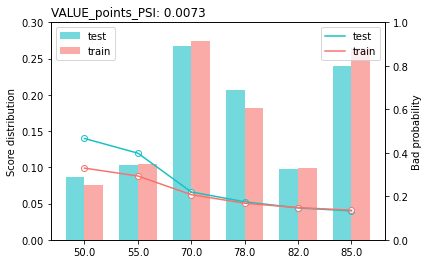

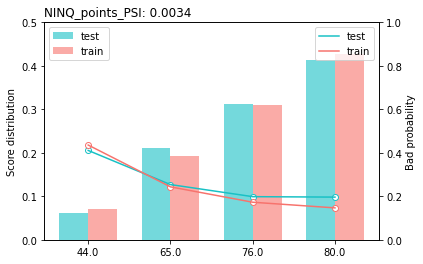

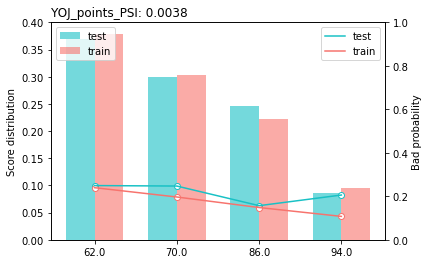

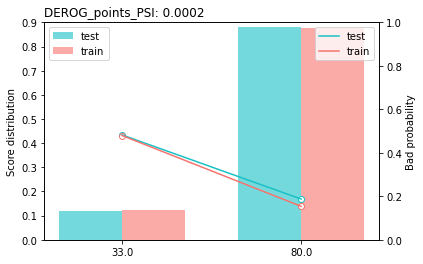

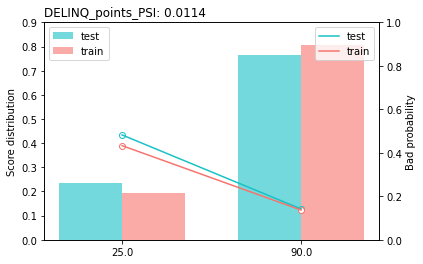

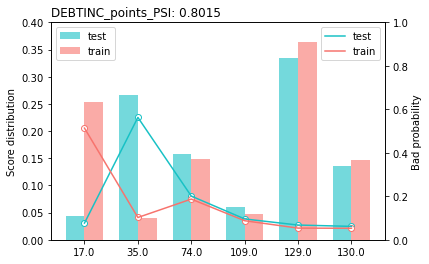

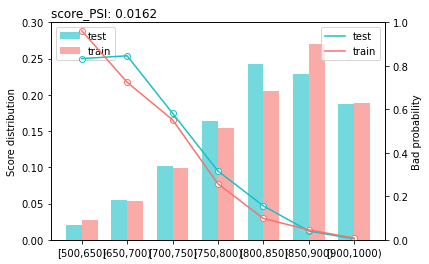

In [44]:
p = sc.perf_psi(score = {'train':train_score, 'test':test_score}, 
        label = {'train':y_train, 'test':y_test},
        return_distr_dat=True)

Toutefois on a vu que pour la variable DEBTINC, on n'a absolument pas de stabilité dans les points délivrés par chaque classe. Mais la Grille de score étant très stable, on considérera cet instabilité comme étant sans grande incidence.

In [80]:
p.keys()

dict_keys(['psi', 'pic', 'dat'])

In [79]:
p["psi"]

,variable,PSI
0,MORTDUE_points,0.001799
1,YOJ_points,0.003823
2,DEBTINC_points,0.801477
3,JOB_points,0.001790
4,VALUE_points,0.007331
5,DEROG_points,0.000166
6,CLAGE_points,0.000723
7,CLNO_points,0.009945
8,LOAN_points,0.009875
9,DELINQ_points,0.011429


La table ci-dessous nous donne notre grille de score finale, il est important de noter que chaque classe de risque correspond à une probabilité de défaut. En effet on observe comme prévu une baisse de la probabilité de défaut lorsque le score augmente. Les individus en bas (en rouge) ne devraient pas voir leur demande acceptée, ceux en haut(en vert) doivent avoir le prêt et ceux en ballottage (en orange) méritent une analyse métier plus approfondie afin de décider.

In [45]:
scorecard_bins = p["dat"]["score"]
scorecard_bins

bin    N         badprob          
ae             test train      test     train
0    [500,650)   24   132  0.833333  0.962121
1    [650,700)   65   254  0.846154  0.724409
2    [700,750)  122   473  0.581967  0.551797
3    [750,800)  196   738  0.316327  0.257453
4    [800,850)  289   979  0.155709  0.098059
5    [850,900)  273  1290  0.040293  0.045736
6   [900,1000)  223   902  0.004484  0.007761

Sur les 1192 individus formant le test set, 75% d'entre eux ont un score inférieur à 886 points, la moyenne étant à 824 et la médiane à 830.5 points. Le plus grand score est de 988 et le plus petit 596. Notons que la volatilité du score est de 78 points.

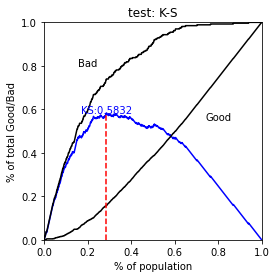

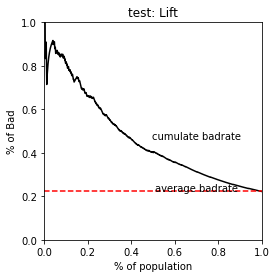

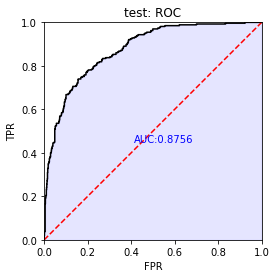

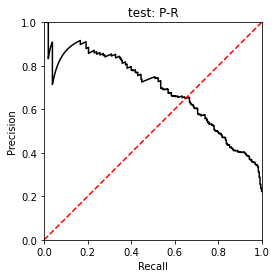

In [46]:
test_perf = sc.perf_eva(y_test, test_pred, title = "test", plot_type=['ks'])
test_perf = sc.perf_eva(y_test, test_pred, title = "test", plot_type=['lift'])
test_perf = sc.perf_eva(y_test, test_pred, title = "test", plot_type=['roc'])
test_perf = sc.perf_eva(y_test, test_pred, title = "test", plot_type=['pr'])

## ***6 - MODEL CHALLENGING***

On a tenté de challenger les résultats du modèle de scoring «classique» précédemment présenté par différents **algorithmes de Machine Learning**. 

Il s’agit du RandomForestClassifier, DecisionTreeClassifier, LinearDiscriminantAnalysis, GradientBoostingClassifier,  KNeighborsClassifier, VotingClassifier et StackingClassifier.

Afin d’optimiser au maximum nos résultats, on a présenté des jeux de paramètres à un algorithme de sélection le **GridSearchCV** qui, par validation croisée, va choisir pour chaque classificateur les paramètres qui **maximisent l’AUC**.

In [48]:
utils.grid_search("RandomForestClassifier",  X_train, y_train )

RandomForestClassifier
------
L'opération a pris 65.78s
Les meilleurs paramètres sont: {'max_depth': 100, 'max_features': 3, 'n_estimators': 25}
Le meilleur score AUC est: 0.81


In [50]:
utils.grid_search("DecisionTreeClassifier",  X_train, y_train )

DecisionTreeClassifier
------
L'opération a pris 6.64s
Les meilleurs paramètres sont: {'max_depth': 4, 'max_features': 10}
Le meilleur score AUC est: 0.84


In [51]:
utils.grid_search("LinearDiscriminantAnalysis",  X_train, y_train )

LinearDiscriminantAnalysis
------
L'opération a pris 0.19s
Les meilleurs paramètres sont: {}
Le meilleur score AUC est: 0.88


In [52]:
utils.grid_search("GradientBoostingClassifier",  X_train, y_train )

GradientBoostingClassifier
------
L'opération a pris 8.29s
Les meilleurs paramètres sont: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 25}
Le meilleur score AUC est: 0.85


In [53]:
utils.grid_search("KNeighborsClassifier", X_train, y_train )

KNeighborsClassifier
------
L'opération a pris 2.92s
Les meilleurs paramètres sont: {'n_neighbors': 35}
Le meilleur score AUC est: 0.87


Après avoir sélectionné les meilleurs paramètres de chacun des classificateurs (permettant de maximiser l'AUC), on construit les modèles et on compare leurs performances.

In [55]:
def model_comp(model, X_train = X_train, y_train = y_train, 
          X_test = X_test, y_test = y_test, 
          smote = True, show_roc = True, show_conf_matrix = False, cut_off = 0.45, show_prc = False) : 
    
    b = re.findall(r"[A-Za-z0-9]+", str(model))
    #Appliquer le smote :
    if smote == True:
        print("SMOTE")
        print("--------")
        smote = SMOTE(random_state=42 , k_neighbors=15)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
    lr = model.fit(X_train, y_train)
    print("train score %.2f" %lr.score(X_train, y_train))
    print("--------")
    
    #Prédiction des y_pred:
    train_pred = lr.predict_proba(X_train)[:,1]
    test_pred = lr.predict_proba(X_test)[:,1]
    print("test score %.2f" %lr.score(X_test, y_test))
    
    print("--------")
    print("Cut-off : ", cut_off)
    
    # Affichage des métriques: accuracy, precision, recall, f1-score au seuil de 50% de confiance (standard)
    print("--------")
    print("classification_report\n")
    test_pred_b = (test_pred > cut_off).astype(bool)
    train_pred_b = (train_pred > cut_off).astype(bool)
    print(classification_report(y_test, test_pred_b))
    print("\n")

    train_pred_b = (train_pred > cut_off).astype(bool)
    
    #Affichage de la matrice de confusion:
    if show_conf_matrix == True : 
        print("Matrice de confusion\n")
        print(confusion_matrix(y_test, test_pred_b))
        print("--------")
    
    #Tracé de la courbe ROC avec l'AUC:
    fpr, tpr, _= roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    fpr_, tpr_, _train= roc_curve(y_train, train_pred)
    roc_auc_ = auc(fpr_, tpr_)
    print("L'AUC est de %.2f" %roc_auc)
    print("--------")
    Gini = roc_auc * 2 - 1
    print('Gini: %.2f' % (Gini))
    print("--------")
    
    if show_roc == True:
        print('roc curve')
        
        plt.figure(figsize=(6,6))
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr, tpr, lw=3, label='roc curve - Test (auc = {:0.2f})'.format(roc_auc))
        #plt.plot(fpr_, tpr_, lw=3, label='roc curve - Train (auc = {:0.2f})'.format(roc_auc_))
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title(b[0], fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.axes().set_aspect('equal')
        plt.show()
        print("\n")
        
       
    precision, recall, thresholds = precision_recall_curve(y_test, test_pred)
    precision_, recall_, thresholds_ = precision_recall_curve(y_train, train_pred)
    
    closest_zero = np.argmin(np.abs(thresholds))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]
    
    closest_zero_ = np.argmin(np.abs(thresholds_))
    closest_zero_p_ = precision_[closest_zero_]
    closest_zero_r_ = recall_[closest_zero_]
    
    if show_prc == True : 
        
        print("precision_recall_curve")
        plt.figure(figsize = (6,6))
        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.plot(precision, recall, label='prc - Test')
        #plt.plot(precision_, recall_, label='prc - Train')
        #plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
        #plt.plot(closest_zero_p_, closest_zero_r_, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
        plt.xlabel('Precision', fontsize=16)
        plt.ylabel('Recall', fontsize=16)
        plt.axes().set_aspect('equal')
        plt.legend(loc='lower left', fontsize=13)
        plt.show()

    J = tpr - fpr
    ix = np.argmax(J)
    seuil_opt = thresholds[ix]
    
    J_ = tpr_ - fpr_
    ix_ = np.argmax(J_)
    seuil_opt_ = thresholds_[ix_]
    print('Meilleur cut-off test : %f' % (seuil_opt))
    print('Meilleur cut-off train : %f' % (seuil_opt_))
    
    return fpr, tpr, roc_auc

On applique cette fonction aux différents modèles:

### RandomForestClassifier:

SMOTE
--------
train score 1.00
--------
test score 0.85
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       927
           1       0.82      0.44      0.57       265

    accuracy                           0.85      1192
   macro avg       0.84      0.71      0.74      1192
weighted avg       0.85      0.85      0.84      1192



L'AUC est de 0.92
--------
Gini: 0.84
--------
roc curve


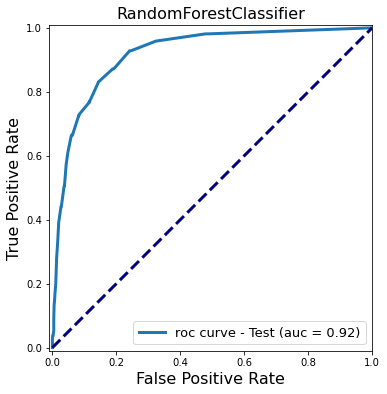



Meilleur cut-off test : 0.480000
Meilleur cut-off train : 0.600000


In [56]:
fpr_r, tpr_r, roc_auc_r = model_comp(model = RandomForestClassifier(max_depth=100, max_features=4, n_estimators = 25, random_state=42))

### DecisionTreeClassifier:

SMOTE
--------
train score 0.82
--------
test score 0.75
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       927
           1       0.43      0.45      0.44       265

    accuracy                           0.74      1192
   macro avg       0.63      0.64      0.64      1192
weighted avg       0.75      0.74      0.75      1192



L'AUC est de 0.69
--------
Gini: 0.39
--------
roc curve


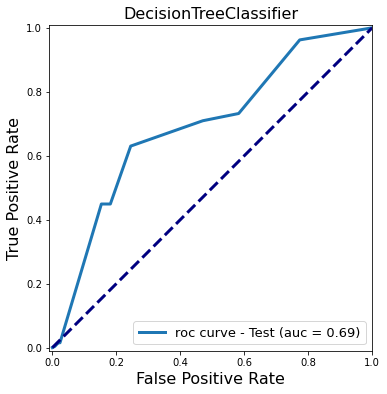



Meilleur cut-off test : 0.735849
Meilleur cut-off train : 0.481481


In [72]:
fpr_d, tpr_d, roc_auc_d = model_comp(model = DecisionTreeClassifier(max_depth=4, max_features=10))

### GradientBoostingClassifier:

SMOTE
--------
train score 0.82
--------
test score 0.81
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       927
           1       0.54      0.59      0.57       265

    accuracy                           0.80      1192
   macro avg       0.71      0.72      0.72      1192
weighted avg       0.80      0.80      0.80      1192



L'AUC est de 0.82
--------
Gini: 0.64
--------
roc curve


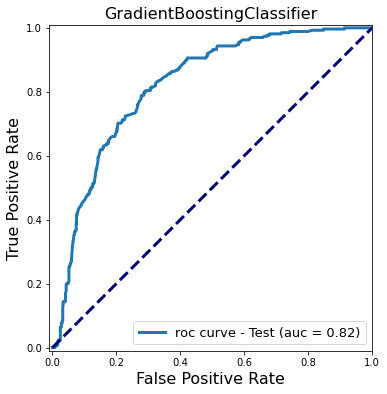



Meilleur cut-off test : 0.277165
Meilleur cut-off train : 0.331099


In [58]:
fpr_gb, tpr_gb, roc_auc_gb = model_comp(model = GradientBoostingClassifier(learning_rate=0.2, max_depth=1, n_estimators=25, random_state= 42))

### LinearDiscriminantAnalysis:

SMOTE
--------
train score 0.80
--------
test score 0.80
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.93      0.78      0.85       927
           1       0.51      0.79      0.62       265

    accuracy                           0.78      1192
   macro avg       0.72      0.79      0.73      1192
weighted avg       0.84      0.78      0.80      1192



L'AUC est de 0.88
--------
Gini: 0.75
--------
roc curve


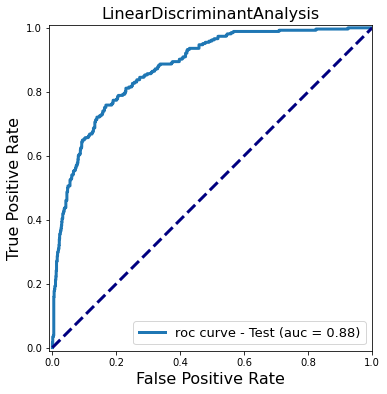



Meilleur cut-off test : 0.061381
Meilleur cut-off train : 0.091038


In [59]:
fpr_lda, tpr_lda, roc_auc_lda = model_comp(model = LinearDiscriminantAnalysis())

### KNeighborsClassifier:

SMOTE
--------
train score 0.84
--------
test score 0.78
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.94      0.71      0.81       927
           1       0.46      0.85      0.59       265

    accuracy                           0.74      1192
   macro avg       0.70      0.78      0.70      1192
weighted avg       0.83      0.74      0.76      1192



L'AUC est de 0.87
--------
Gini: 0.75
--------
roc curve


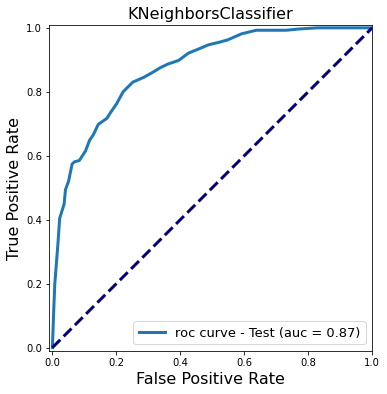



Meilleur cut-off test : 0.542857
Meilleur cut-off train : 0.514286


In [73]:
fpr_knn, tpr_knn, roc_auc_knn = model_comp(model = KNeighborsClassifier(n_neighbors=35))

On a décidé de comparer les performances des modèles précédents avec celles obtenues avec un VotingClassifier ou un StackingClassifier.

### VotingClassifier:

Il agrège les résultats de chaque classificateur et prédit la classe de sortie en fonction de la plus grande majorité des votes. 

SMOTE
--------
train score 0.92
--------
test score 0.87
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       927
           1       0.68      0.71      0.69       265

    accuracy                           0.86      1192
   macro avg       0.80      0.81      0.80      1192
weighted avg       0.86      0.86      0.86      1192



L'AUC est de 0.90
--------
Gini: 0.79
--------
roc curve


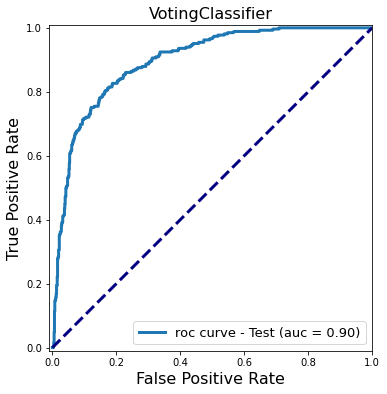



Meilleur cut-off test : 0.127919
Meilleur cut-off train : 0.178599


In [77]:
clf1 = KNeighborsClassifier(n_neighbors=35)
clf2 = RandomForestClassifier(max_depth=75, max_features=3, n_estimators = 25, random_state=42)
clf3 = LogisticRegression(penalty='l2', C=15, max_iter= 100, random_state=42)
clf4 = LinearDiscriminantAnalysis()
clf5 = DecisionTreeClassifier(max_depth=8, max_features=9)
clf6 = GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=25, random_state=2)


estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3), ('lda', clf4), ('dt', clf5), ('gb', clf6)]

#VotingClassifier:
vclf = VotingClassifier(estimators, voting='soft')
fpr_vc, tpr_vc, roc_auc_vc = model_comp(model = vclf)

### StackingClassifier:

L’empilage est une technique d’apprentissage d’ensemble permettant de combiner plusieurs modèles de classification via un métaclassifieur. Ce dernier peut être entraîné sur les étiquettes de classe prédites ou sur les probabilités de l’ensemble.

On combine ainsi les algorithmes précédents et on affiche les performances du StackingClassifier:

SMOTE
--------
train score 1.00
--------
test score 0.84
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       927
           1       0.83      0.46      0.59       265

    accuracy                           0.86      1192
   macro avg       0.85      0.72      0.75      1192
weighted avg       0.86      0.86      0.84      1192



L'AUC est de 0.93
--------
Gini: 0.85
--------
roc curve


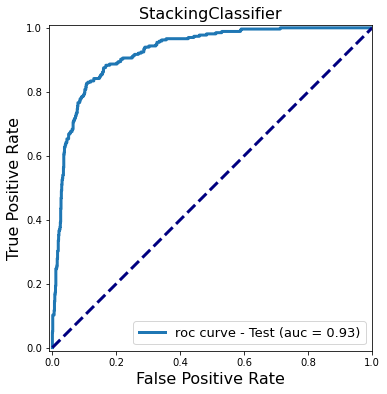



Meilleur cut-off test : 0.013508
Meilleur cut-off train : 0.068044


In [78]:
sclf = StackingClassifier(estimators)
fpr_sc, tpr_sc, roc_auc_sc = model_comp(model = sclf)

#### Courbe ROC de tous les algorithmes de Machine Learning testés:

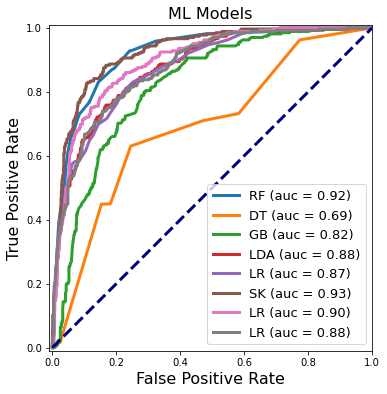

In [79]:
plt.figure(figsize=(6,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_r, tpr_r, lw=3, label='RF (auc = {:0.2f})'.format(roc_auc_r))
plt.plot(fpr_d, tpr_d, lw=3, label='DT (auc = {:0.2f})'.format(roc_auc_d))
plt.plot(fpr_gb, tpr_gb, lw=3, label='GB (auc = {:0.2f})'.format(roc_auc_gb))
plt.plot(fpr_lda, tpr_lda, lw=3, label='LDA (auc = {:0.2f})'.format(roc_auc_lda))
plt.plot(fpr_knn, tpr_knn, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc_knn))

plt.plot(fpr_sc, tpr_sc, lw=3, label='SK (auc = {:0.2f})'.format(roc_auc_sc))
plt.plot(fpr_vc, tpr_vc, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc_vc))
plt.plot(fpr, tpr, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ML Models', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

- On remarque que globalement le **RandomForestClassifier** donne des résultats très bons. Concernant l’AUC, il détient la pôle avec le **StackingClassifier**. 

- On voit que le **DecisionTreeClassifier** est le pire des algorithmes. Notre problème étant orienté recall, on se rend compte que ses performances comparées au **KNeighborsClassifier** ne sont pas très bonnes. 

- Le modèle le plus équilibré est le **VotingClassifier** qui présente le F1 score le plus élevé et son AUC est aussi appréciable. 

Toutefois, même si les algorithmes de ML se débrouillent pas mal, on préférera la logistique pour construire notre Grille de score en raison de son interprétabilité et de sa capacité à être facilement explicable.